**MUQING WEN, ZHOUYI QIAN**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 2: MNIST and Unsupervised learning with Oja's rule in a competitive network

# Project 1: Hebbian Learning

This week you will implement the bio-inspired network that learns according to Hebb's Rule. Once you train the Hebbian network, your goal is to compare the classification accuracy on MNIST achieved by the two decoders networks that you implemented last week.

They are called **decoders** because the "samples" fed into the decoder are in fact the outputs of the Hebbian network to the original data samples. The job of the decoder network is to predict the correct class label given the Hebbian network activations — *not* the original sample. For example, the decoder will try to correctly predict `9` by only "looking at" the pattern of neural activation that was produced when the `9` was presented to the Hebbian network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import time

from mnist import get_mnist

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)

%load_ext autoreload
%autoreload 2

## Task 3: MNIST dataset

This task focuses on accessing and preprocessing the MNIST dataset, which you will use to train bio-inspired Hebbian neural network. MNIST has 60,000 training samples and 10,000 test samples. Each sample is a `28x28` image of a hand written digit. The digit in each sample image is the class label. The digit may be any in the range `0-9` ($C = 10$).

### 3a. Load and preprocess MNIST

Implement and test `get_mnist(N_val, path)` in `mnist.py` to load in MNIST, preprocess the dataset, then create train/validation/test splits.

In [2]:
x_train, y_train, x_test, y_test, x_val, y_val = get_mnist(100)

print('Preprocessed shapes:')
print(f'{x_train.shape=} {x_test.shape=} {x_val.shape=}\n{y_train.shape=} {y_test.shape=} {y_val.shape=}')
print('--------------')
print(f'Train min/max: {x_train.min()}/{x_train.max()}')
print(f'Validation min/max: {x_val.min()}/{x_val.max()}')
print(f'Test min/max: {x_test.min()}/{x_test.max()}')
print(f'Labels in training set: {np.unique(y_train)}')
print(f'Labels in validation set: {np.unique(y_val)}')
print(f'Labels in test set: {np.unique(y_test)}')

print(80*'-')
print('You should see:')
print(80*'-')
print('''Preprocessed shapes:
x_train.shape=(59900, 784) x_test.shape=(10000, 784) x_val.shape=(100, 784)
y_train.shape=(59900,) y_test.shape=(10000,) y_val.shape=(100,)
--------------
Train min/max: 0.0/1.0
Validation min/max: 0.0/1.0
Test min/max: 0.0/1.0
Labels in training set: [0 1 2 3 4 5 6 7 8 9]
Labels in validation set: [0 1 2 3 4 5 6 7 8 9]
Labels in test set: [0 1 2 3 4 5 6 7 8 9]
''')

Preprocessed shapes:
x_train.shape=(59900, 784) x_test.shape=(10000, 784) x_val.shape=(100, 784)
y_train.shape=(59900,) y_test.shape=(10000,) y_val.shape=(100,)
--------------
Train min/max: 0.0/1.0
Validation min/max: 0.0/1.0
Test min/max: 0.0/1.0
Labels in training set: [0 1 2 3 4 5 6 7 8 9]
Labels in validation set: [0 1 2 3 4 5 6 7 8 9]
Labels in test set: [0 1 2 3 4 5 6 7 8 9]
--------------------------------------------------------------------------------
You should see:
--------------------------------------------------------------------------------
Preprocessed shapes:
x_train.shape=(59900, 784) x_test.shape=(10000, 784) x_val.shape=(100, 784)
y_train.shape=(59900,) y_test.shape=(10000,) y_val.shape=(100,)
--------------
Train min/max: 0.0/1.0
Validation min/max: 0.0/1.0
Test min/max: 0.0/1.0
Labels in training set: [0 1 2 3 4 5 6 7 8 9]
Labels in validation set: [0 1 2 3 4 5 6 7 8 9]
Labels in test set: [0 1 2 3 4 5 6 7 8 9]



### 3b. Visualize MNIST samples

Use `draw_grid_image()` in `viz.py` in the cell below to create a `10x10` grid of the 100 MNIST sample images.

This function places the image samples on a *single canvas* image (i.e. does not create subplots). The reason for this is that you will call this function while training the unsupervised Hebbian network to visualize the weights *live*! Plotting one image instead an 2D array is more efficient!

If you selected the first `N_val` samples for your validation set, the first two rows of your image should consist of the following digits:

```
[[0 9 2 3 7 3 8 9 7 9]
 [0 8 2 2 3 3 6 3 4 1]]
```

In [3]:
from viz import draw_grid_image

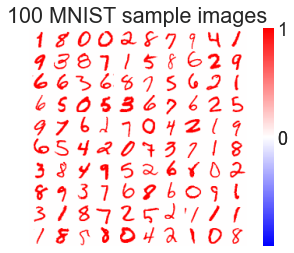

In [4]:
draw_grid_image(x=x_val, n_cols=10, n_rows=10, sample_dims=(28, 28, 1), title='100 MNIST sample images')

## Task 4: Hebbian network with Oja's Rule

Implement the Hebbian learning network in `hebb.net.py` and test it using the cells below.

In [26]:
from hebb_net import HebbNet

### 4a. Start implementing Hebbian network (`HebbNet` class)

Implement the following methods in `hebb_net.py`:
- Constructor
- `get_wts(self)`
- `set_wts(self, wts)`
- `net_in(self, x)`

The network uses the usual Dense net in:

$$\text{netIn}_{ih} = y_{ih} = \sum_{j=1}^M x_{ij} w_{jh}$$


#### Test: `net_in`

In [27]:
N, M, H = 3, 10, 6

np.random.seed(0)
x = np.random.random(size=(N, M))

net = HebbNet(M, H, kth_place_inhibited=3)
print(f'Your net_in is:\n{net.net_in(x)}\nand it should be:')
print('[[3.099 2.038 3.871 2.152 2.219 2.462]\n [2.803 2.16  3.206 2.066 2.096 2.394]\n [2.873 2.409 3.652 2.177 2.035 2.285]]')

Your net_in is:
[[3.099 2.038 3.871 2.152 2.219 2.462]
 [2.803 2.16  3.206 2.066 2.096 2.394]
 [2.873 2.409 3.652 2.177 2.035 2.285]]
and it should be:
[[3.099 2.038 3.871 2.152 2.219 2.462]
 [2.803 2.16  3.206 2.066 2.096 2.394]
 [2.873 2.409 3.652 2.177 2.035 2.285]]


### 4b. Hebbian network activation


The activation in the Hebbian network (`netAct`) to each sample $i$ in neuron $h$ implements a **competitive** process:

$$\text{netAct}_{ih} = f(y_{ih})  =
\begin{cases}
      1, & \text{if}\ h = argmax_h (\text{netIn}_{ih}) \text{ i.e neuron } h \text{ comes in 1st place} \\
      -\Delta, & \text{if neuron }\ h \text{ comes in } k^{\text{th}} \text{ place} \\
      0, & \text{otherwise}
\end{cases}$$

Notes about the above netAct equation:

- "1st place" refer to the neuron that achieves the highest netIn values.
- "$k^{\text{th}}$ place" refers to the neuron that achieves the $k^{\text{th}}$ highest netIn value. For example, $k=2$ refers to the "2nd place" neuron that achieves the 2nd highest netIn.
- $k^{\text{th}}$ place is defined in the usual "human-interpretable" rather than an "Python indexing" sense (i.e. $k=2$ for second place, $k=3$ for third place, etc.)

Implement the neural competition in the `net_act(self, net_in)` method then test it below.

#### Test: net_act

In [36]:
a = np.array([[1, 2, 3, 4], [8, 5, 6, 7], [11, 12, 9, 10]])
s_idx = np.argsort(a, axis=1)
print(s_idx)

max_idx = s_idx[:, -1]
print(a.shape)
print(max_idx)
print(a[np.arange(a.shape[0]), max_idx])
a[np.arange(a.shape[0]), max_idx] = 0
print(a)
b = np.zeros((3, 4))
print(b)
c = np.array([[0, 1, 2, 3],[4, 5, 6, 7]])
c = np.flip(c, axis=1)
print(c)

[[0 1 2 3]
 [1 2 3 0]
 [2 3 0 1]]
(3, 4)
[3 0 1]
[ 4  8 12]
[[ 1  2  3  0]
 [ 0  5  6  7]
 [11  0  9 10]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[3 2 1 0]
 [7 6 5 4]]


In [29]:
def test_net_act(x, M, H, kth_place_inhibited, inhib_value):
    '''net_act tester function'''
    np.random.seed(0)
    net = HebbNet(M, H, kth_place_inhibited=kth_place_inhibited, inhib_value=inhib_value)
    net_in = net.net_in(x)
    print(f"The net_in is:\n{np.array2string(net_in, precision=1, floatmode='fixed')}:")
    print(f'So your net_act is:\n{net.net_act(net_in)}\nand it should be:')

In [47]:
# Simplest test
print('Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('[[0. 0. 0. 1. 0.]]')

Test 1: Simplest test with 1 sample and no inhibition (only winner-take-all)
The net_in is:
[[1.8 1.6 2.4 2.5 1.2]]:
So your net_act is:
[[0. 0. 0. 1. 0.]]
and it should be:
[[0. 0. 0. 1. 0.]]


In [51]:
# Test with additional samples
print(70*'-')
print('Test 2: 3 samples and no inhibition (only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0)
print('''[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]''')

print(70*'-')
print('Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=1, inhib_value=0)
print('''[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]''')

----------------------------------------------------------------------
Test 2: 3 samples and no inhibition (only winner-take-all)
The net_in is:
[[2.2 1.5 2.0 2.8 0.5]
 [1.3 1.2 1.2 1.5 0.5]
 [6.1 7.6 6.9 6.4 4.6]]:
So your net_act is:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
and it should be:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
----------------------------------------------------------------------
Test 3: This should still work — 3 samples and no inhibition targeting winner (still only winner-take-all)
The net_in is:
[[2.2 1.5 2.0 2.8 0.5]
 [1.3 1.2 1.2 1.5 0.5]
 [6.1 7.6 6.9 6.4 4.6]]:
So your net_act is:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
and it should be:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [52]:
# Tests with 2nd place inhibited
print('Test 4: Test with 1 sample, 2nd place inhibited')
x = np.array([[1, 2, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0.5)
print('[[ 0.   0.  -0.5  1.   0. ]]')

print(70*'-')
print('Test 5: 3 samples, 2nd place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=2, inhib_value=0.5)
print('''[[-0.5  0.   0.   1.   0. ]
 [-0.5  0.   0.   1.   0. ]
 [ 0.   1.  -0.5  0.   0. ]]''')

Test 4: Test with 1 sample, 2nd place inhibited
The net_in is:
[[1.8 1.6 2.4 2.5 1.2]]:
So your net_act is:
[[ 0.   0.  -0.5  1.   0. ]]
and it should be:
[[ 0.   0.  -0.5  1.   0. ]]
----------------------------------------------------------------------
Test 5: 3 samples, 2nd place inhibited
The net_in is:
[[2.2 1.5 2.0 2.8 0.5]
 [1.3 1.2 1.2 1.5 0.5]
 [6.1 7.6 6.9 6.4 4.6]]:
So your net_act is:
[[-0.5  0.   0.   1.   0. ]
 [-0.5  0.   0.   1.   0. ]
 [ 0.   1.  -0.5  0.   0. ]]
and it should be:
[[-0.5  0.   0.   1.   0. ]
 [-0.5  0.   0.   1.   0. ]
 [ 0.   1.  -0.5  0.   0. ]]


In [53]:
# Tests with 2nd place inhibited
print('Test 6: Test with 3 samples, 4th place inhibited')
x = np.array([[0, 1, 2], [1, 0, 1], [10, 1, 0]])
test_net_act(x, M=3, H=5, kth_place_inhibited=4, inhib_value=0.25)
print('''[[ 0.   -0.25  0.    1.    0.  ]
 [ 0.    0.   -0.25  1.    0.  ]
 [-0.25  1.    0.    0.    0.  ]]''')

Test 6: Test with 3 samples, 4th place inhibited
The net_in is:
[[2.2 1.5 2.0 2.8 0.5]
 [1.3 1.2 1.2 1.5 0.5]
 [6.1 7.6 6.9 6.4 4.6]]:
So your net_act is:
[[ 0.   -0.25  0.    1.    0.  ]
 [ 0.    0.   -0.25  1.    0.  ]
 [-0.25  1.    0.    0.    0.  ]]
and it should be:
[[ 0.   -0.25  0.    1.    0.  ]
 [ 0.    0.   -0.25  1.    0.  ]
 [-0.25  1.    0.    0.    0.  ]]


### 4c. Hebbian weight update

The competitive Hebbian network uses the Competitive Oja's Rule for weight updates:

$$
\text{dw}_{jh} = \sum_{i=1}^Bx_i\text{netAct}_{ih} - w_{jh}\sum_{i=1}^B\text{netAct}_{ih}\text{netIn}_{ih}
$$

Competitive Oja's Rule (same equation written in math notation):
$$
\text{dw}_{jh} = \sum_{i=1}^B f(y_{ih}) \left ( x_i - y_{ih}w_{jh} \right )
$$

Two-step weight update rule:
$$
w_{jh}(t) = w_{jh}(t-1) + \eta \text{dw}_{jh}
$$

$$
w_{jh}(t) = \frac{w_{jh}(t)}{\max{|w(t) |} + \epsilon}
$$

where $\max{|w(t) |}$ is the absolute value of the maximum of all the weights and $\epsilon$ is a small positive number to prevent possible division by 0.

Implement the neural competition in the `update_wts(self, x, net_in, net_act, lr, eps=1e-10)` method then test it below.

#### Test: `update_wts`

In [ ]:
N, M, H = 3, 10, 6

np.random.seed(0)
x = np.random.random(size=(N, M))

net = HebbNet(M, H, kth_place_inhibited=3)
net_in = net.net_in(x)
net_act = net.net_act(net_in)
net.update_wts(x, net_in, net_act, lr=0.5)
print(f'Your wts after 1 update are:\n{net.get_wts()}\nand it should be:')
print('''[[0.265 0.795 0.303 0.568 0.019 0.657]
 [0.612 0.633 0.462 0.682 0.36  0.458]
 [0.698 0.053 0.338 0.671 0.21  0.116]
 [0.315 0.366 0.34  0.439 0.988 0.079]
 [0.209 0.168 0.272 0.253 0.466 0.261]
 [0.159 0.101 0.318 0.138 0.197 0.394]
 [0.821 0.099 0.338 0.096 0.976 0.512]
 [0.977 0.617 0.426 0.039 0.283 0.093]
 [0.296 0.113 0.25  0.414 0.064 0.731]
 [0.567 0.271 0.288 0.094 0.576 1.007]]''')

### 4d. Implement `fit` and train Hebbian network on MNIST

Now is the time to train your Hebbian network on the MNIST training set! Implement the `fit` method and train your Hebbian network with the below hyperparameters.

#### Goal

The goal is to train the Hebbian network so that the netAct values provide an accurate encoding of the MNIST digits. Once the network weights enable this (after the training that you do in this task), next week you will train your neural decoders on the Hebbian network netAct values obtained for the MNIST training set, then you will have your decoder try to classify the MNIST digits given the Hebbian network netAct values obtained for the MNIST test set.

#### Live plotting/animation

You will want to set `plot_wts_live`: set to True so that you can visualize the weights dynamically during training every `print_every` epochs! It's really cool to see the learning process in action and it's also a great debugging tool! To allow the Jupyter notebook to show live updates everytime `draw_grid_image` is called, execute the following command before training:

```
%matplotlib notebook
```

This will make other plots in the notebook a little wonky so after the cell / after training is done, you'll want to revert the plotting mode back to the Jupyter default:

```
%matplotlib inline
```

You will want to get this working — it is worth it!

**NOTE:** Dynamic plot animations/updates are not supported in VS Code. So to see the plots update live, you will need to switch to opening Jupyter in the browser via Terminal.

#### Hyperparameters

- Take 2000 samples out of the training set for the validation set (*the validation set won't be used until training the decoders, but we only want to train the Hebbian network on the final 58000 sample training set)*
- 50 epochs
- 500 neurons
- 100 sample mini-batch size
- $k = 6$ neurons that achieve the 6th highest netIn should be inhibited to $-\Delta$
- $\Delta = 0.4$
- `2e-2` learning rate

#### Tips
- If your dynamic weight plots (after epoch 0) look mostly white with some red streaks, try transposing your weight matrix before passing it into `draw_grid_image`!
- Your weights should range from (roughly) (-0.25, +0.25)
- **I highly recommend saving the network weights if your network once training is done in `fit` (the default). This will save you a lot of time later when working with the decoders.** 
- Training is expected to take 5-15 mins depending on your machine and implementation.

In [ ]:
%matplotlib notebook


### 4e. Plot final Hebbian network weights

Use `draw_grid_image` to create a plot of the weights of 100 neurons (e.g. in a 10x10 grid).

In [ ]:
from viz import draw_grid_image

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))


### 4f. Questions

**Question 6:** Do the network weights exactly match specific samples in the dataset? Why or why not?

**Question 7:** Interpret the meaning of the positive and negative values within the same neuron's weights. How do these factors affect processing? It might be helpful to refer to specific example(s) in your visualization.

**Question 8:** Train your network when the competition is "winner-take-all" — the winner gets activation 1 and every other neuron gets activation 0. Generate a plot of the weights. How are they qualitatively different from before? *You shouldn't need to train for long to see the difference.*

**Answer 6:**

**Answer 7:**

**Answer 8:**